# Week 9

This week, we cover decision trees for classification and regression. Decision trees are highly *interpretable* models because they create an explicit set of single-feature-based rules for making their predictions.

Decision trees are interpretable and they train very quickly, but the set of rules is sometimes too large to be helpful and they have high variance, meaning they are very sensitive to small changes to the training data. We will explore some ways to deal with these downsides as well.

# Lecture 16 - Implementing Decision Trees

We will use the following (slightly modified) tutorial from https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html.

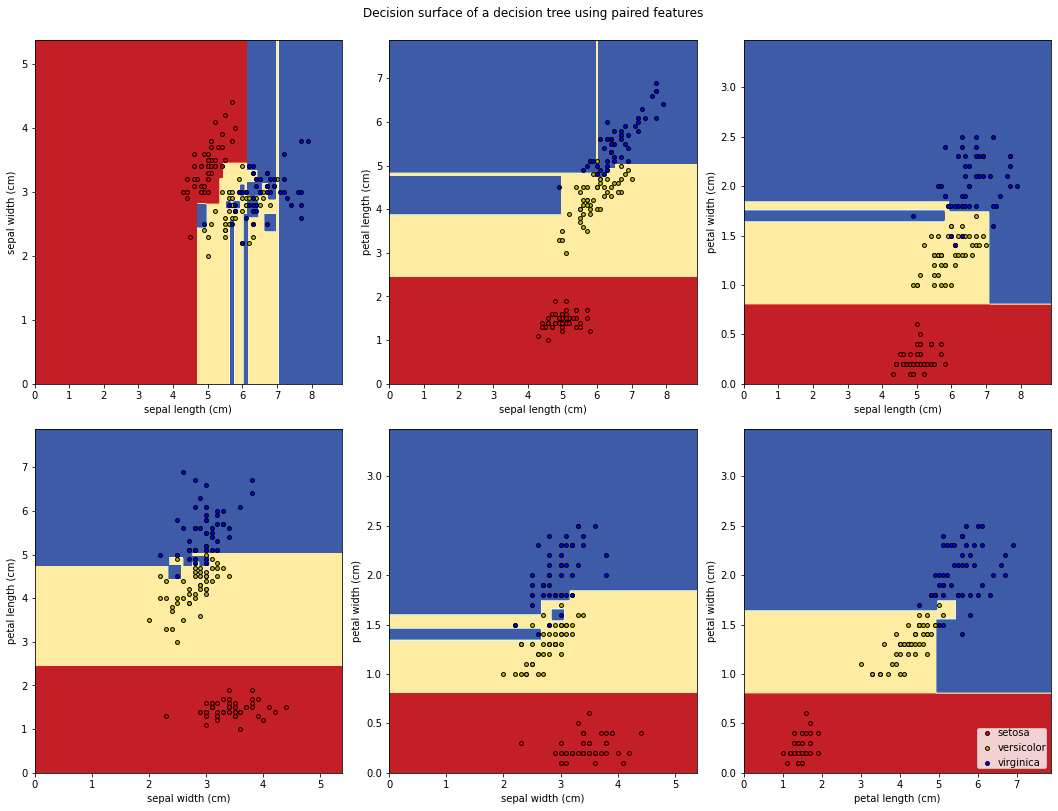

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree

# hyperparameters
n_classes = 3
plot_colors = 'ryb'
plot_step = 0.02

# Load the iris dataset
iris = load_iris()

plt.figure(figsize=(16,12))

# run the model for each pair of features
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    # take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # fit the classifier
    clf = DecisionTreeClassifier().fit(X, y)

    # plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    # predict the testing data on a tight mesh of points in space and color-code them
    x_min, x_max = 0, X[:, 0].max() + 1
    y_min, y_max = 0, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

    plt.tight_layout(h_pad=1, w_pad=1, pad=5)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    # plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i], cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle('Decision surface of a decision tree using paired features')
plt.legend(loc='lower right', borderpad=0, handletextpad=0)

[Text(446.4, 597.96, 'petal width (cm) <= 0.8\ngini = 0.667\nsamples = 150\nvalue = [50, 50, 50]\nclass = setosa'),
 Text(377.7230769230769, 489.24, 'gini = 0.0\nsamples = 50\nvalue = [50, 0, 0]\nclass = setosa'),
 Text(515.0769230769231, 489.24, 'petal width (cm) <= 1.75\ngini = 0.5\nsamples = 100\nvalue = [0, 50, 50]\nclass = versicolor'),
 Text(274.7076923076923, 380.52000000000004, 'petal length (cm) <= 4.95\ngini = 0.168\nsamples = 54\nvalue = [0, 49, 5]\nclass = versicolor'),
 Text(137.35384615384615, 271.8, 'petal width (cm) <= 1.65\ngini = 0.041\nsamples = 48\nvalue = [0, 47, 1]\nclass = versicolor'),
 Text(68.67692307692307, 163.07999999999998, 'gini = 0.0\nsamples = 47\nvalue = [0, 47, 0]\nclass = versicolor'),
 Text(206.03076923076924, 163.07999999999998, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]\nclass = virginica'),
 Text(412.0615384615385, 271.8, 'petal width (cm) <= 1.55\ngini = 0.444\nsamples = 6\nvalue = [0, 2, 4]\nclass = virginica'),
 Text(343.38461538461536, 163.0

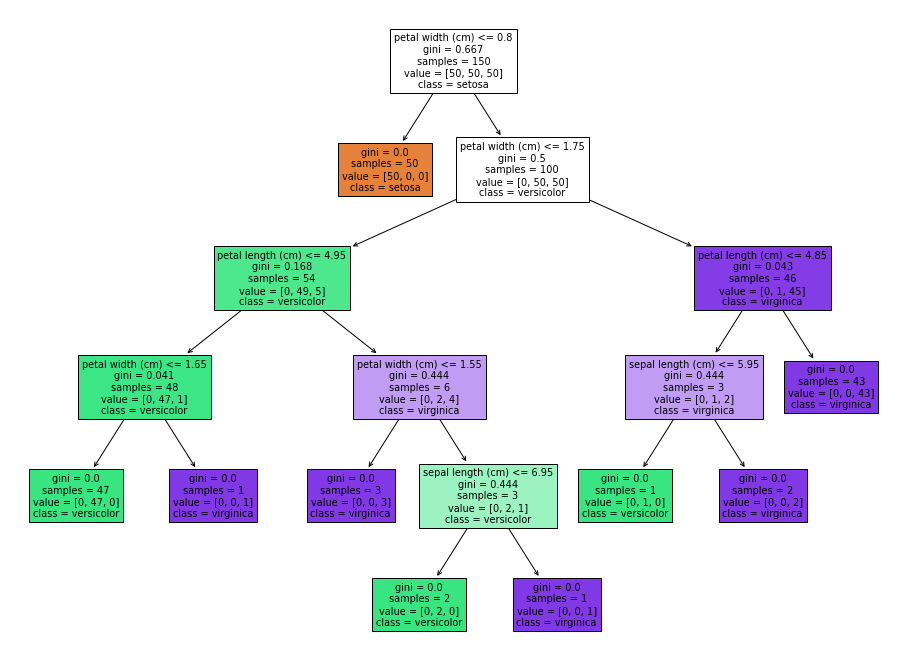

In [2]:
# plot a tree fit to the whole dataset
clf = DecisionTreeClassifier().fit(iris.data, iris.target)
plt.figure(figsize=(16,12))
plot_tree(clf, filled=True, feature_names = iris.feature_names, class_names = iris.target_names)

# Lecture 17 - Pruning, Regression Trees, and Bagging

## Cost-complexity Pruning

We will use some ideas from the `scikit-learn` documentation at https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

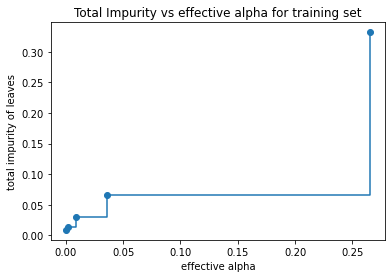

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# create the classifier
clf = DecisionTreeClassifier(random_state=0)

# do cost-complexity pruning
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# plotting the impurities for different alphas
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Next, we train a decision tree using the effective alphas. The last value in `ccp_alphas` is the alpha value that prunes the whole tree, leaving the tree, `clfs[-1]`, with one node.

In [4]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.332795493197279


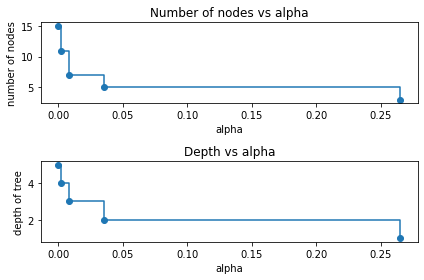

In [5]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

For the remainder of this example, we remove the last element in `clfs` and `ccp_alphas`, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

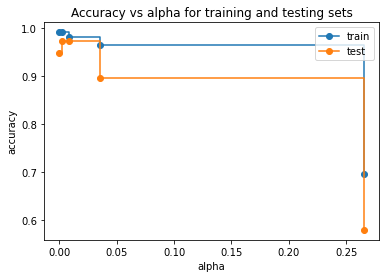

In [6]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

When `ccp_alpha` is set to zero and keeping the other default parameters of DecisionTreeClassifier, the tree overfits, leading to a 100% training accuracy and 88% testing accuracy. As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better. In this example, setting `ccp_alpha = 0.015` maximizes the testing accuracy.

### Regression Trees

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree

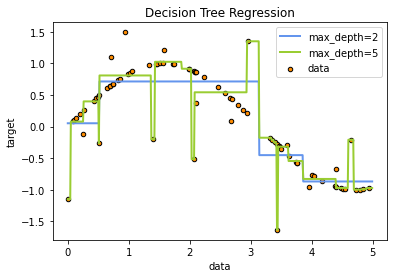

In [8]:
# code from https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

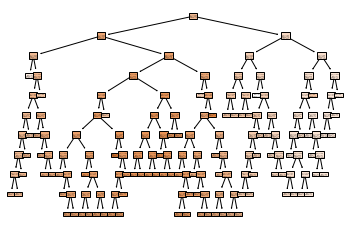

In [9]:
clf = DecisionTreeRegressor().fit(X, y)
plot_tree(clf, filled=True)
plt.show()

In [10]:
diabetes = load_diabetes()

In [11]:
print(diabetes['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [12]:
# read the data and target
X = diabetes['data']
y = diabetes['target']

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.25, random_state = 1)

# create the model
model = DecisionTreeRegressor()

# fit the model to thet training data
model.fit(trainX, trainY)

# predict the outputs for training data
trainPredictions = model.predict(trainX)

# predict the outputs for training data
testPredictions = model.predict(testX)

# compute the training and test mean absolute error
trainError = mean_absolute_error(trainY, trainPredictions)
testError = mean_absolute_error(testY, testPredictions)
    
# return quality metrics
print('The r^2 score is', r2_score(trainY, trainPredictions))
print('The mean absolute error on the training set is', trainError)
print('The mean absolute error on the testing set is', testError)

The r^2 score is 1.0
The mean absolute error on the training set is 0.0
The mean absolute error on the testing set is 64.35135135135135


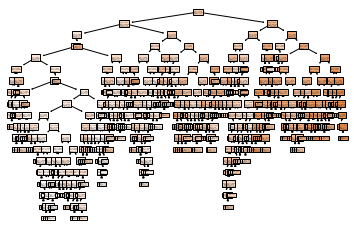

In [13]:
model = DecisionTreeRegressor().fit(trainX, trainY)
plot_tree(model, filled=True)
plt.show()

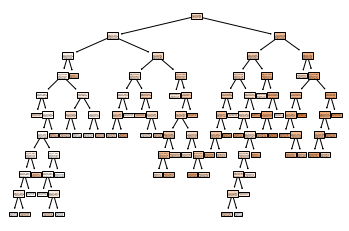

The r^2 score is 0.8631220218349267
The mean absolute error on the training set is 23.477397815513534
The mean absolute error on the testing set is 58.06356485414456


In [14]:
model = DecisionTreeRegressor(ccp_alpha = 20).fit(trainX, trainY)
plot_tree(model, filled=True)
plt.show()

# predict the outputs for training data
trainPredictions = model.predict(trainX)

# predict the outputs for training data
testPredictions = model.predict(testX)

# compute the training and test mean absolute error
trainError = mean_absolute_error(trainY, trainPredictions)
testError = mean_absolute_error(testY, testPredictions)
    
# return quality metrics
print('The r^2 score is', r2_score(trainY, trainPredictions))
print('The mean absolute error on the training set is', trainError)
print('The mean absolute error on the testing set is', testError)

Bagging has the effect of reducing variance in our models.

(This code is from https://scikit-learn.org/stable/auto_examples/ensemble/plot_bias_variance.html)

Tree: 0.0255 (error) = 0.0003 (bias^2)  + 0.0152 (var) + 0.0098 (noise)
Bagging(Tree): 0.0196 (error) = 0.0004 (bias^2)  + 0.0092 (var) + 0.0098 (noise)


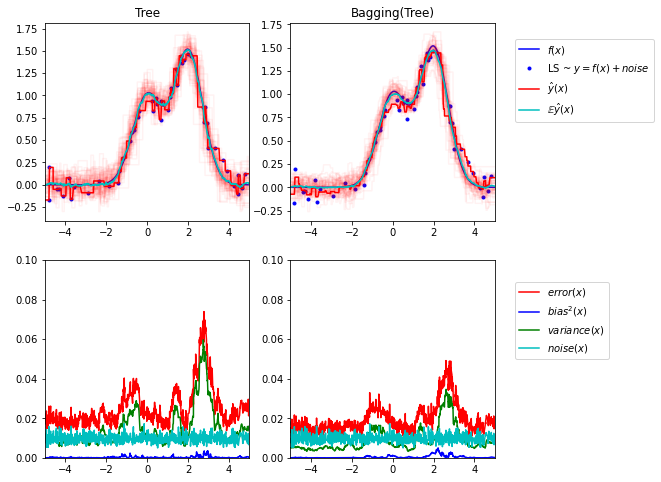

In [15]:
# Author: Gilles Louppe <g.louppe@gmail.com>
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# Settings
n_repeat = 50       # Number of iterations for computing expectations
n_train = 50        # Size of the training set
n_test = 1000       # Size of the test set
noise = 0.1         # Standard deviation of the noise
np.random.seed(0)

# Change this for exploring the bias-variance decomposition of other
# estimators. This should work well for estimators with high variance (e.g.,
# decision trees or KNN), but poorly for estimators with low variance (e.g.,
# linear models).
estimators = [("Tree", DecisionTreeRegressor()), ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor()))]

n_estimators = len(estimators)


####### Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X)

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples)
    else:
        y = np.zeros((n_samples, n_repeat))

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples)

    X = X.reshape((n_samples, 1))

    return X, y

# generate n_repeat instances of training data
X_train = []
y_train = []

for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

# generate test data
X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

# adjust figure size
plt.figure(figsize=(10, 8))

# loop over estimators to compare
for n, (name, estimator) in enumerate(estimators):
    
    # compute predictions
    y_predict = np.zeros((n_test, n_repeat))
    
    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test)

    # Bias^2 + Variance + Noise decomposition of the mean squared error
    y_error = np.zeros(n_test)

    # SSE at the test points
    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2

    y_error /= (n_repeat * n_repeat)

    # noise in test outputs
    y_noise = np.var(y_test, axis=1)
    
    # squared bias (true values - mean of predictions)^2
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2
    
    # variance in the predictions
    y_var = np.var(y_predict, axis=1)

    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    ######## plot figures
    plt.subplot(2, n_estimators, n + 1)
    
    # plot true curve
    plt.plot(X_test, f(X_test), "b", label="$f(x)$")
    
    # plot the training data
    plt.plot(X_train[0], y_train[0], ".b", label="LS ~ $y = f(x)+noise$")

    # plot the predicted curve
    for i in range(n_repeat):
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "r", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "r", alpha=0.05)

    # plot the mean y predictions across model fits
    plt.plot(X_test, np.mean(y_predict, axis=1), "c", label=r"$\mathbb{E} \^y(x)$")

    ######## plot details
    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.subplots_adjust(right=.75)
plt.show()

## Bagging

Next, let's try to compare some classifiers with and without bagging. Decision trees are most commonly used with bagging since they have high variance: small changes in the data can result in drastically different trees. By bagging the trees, we can average over many models taking different random samples of the input data.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.datasets import load_wine
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

### Example: Wine Dataset with Bagged Trees

In [24]:
wine = load_wine()

print(wine['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

First, let's fit a single decision tree classifier to the dataset.


Training Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        40

    accuracy                           1.00       133
   macro avg       1.00      1.00      1.00       133
weighted avg       1.00      1.00      1.00       133


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.90      0.95        20
           2       0.89      1.00      0.94         8

    accuracy                           0.96        45
   macro avg       0.94      0.97      0.95        45
weighted avg       0.96      0.96      0.96        45


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

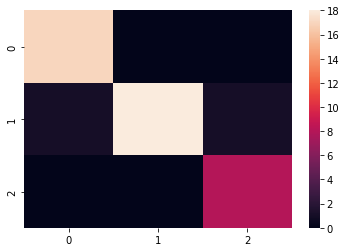

<Figure size 432x288 with 0 Axes>

In [49]:
X = wine['data']
Y = wine['target']

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25)

# build the classifier
model = DecisionTreeClassifier()

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

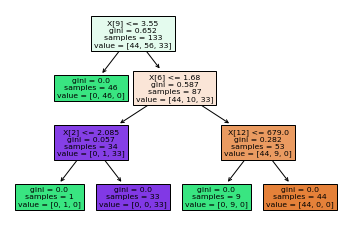

In [48]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25)

# build the classifier
model = DecisionTreeClassifier()

# fit the classifier to the training data
model.fit(trainX, trainY)

# plot the decision tree
plot_tree(model, filled=True)
plt.show()

Note that if we run this multiple times with different random train-test splits, we get very different trees! This is the high variance of the model in action.

Let's try bagging.


Training Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        49
           2       1.00      1.00      1.00        39

    accuracy                           1.00       133
   macro avg       1.00      1.00      1.00       133
weighted avg       1.00      1.00      1.00       133


Testing Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        22
           2       1.00      1.00      1.00         9

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

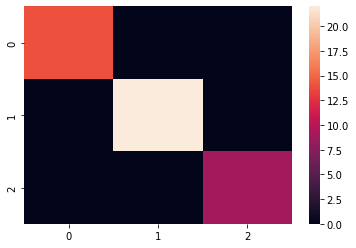

<Figure size 432x288 with 0 Axes>

In [52]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25)

# build the classifier
model = BaggingClassifier(base_estimator = DecisionTreeClassifier(), n_estimators = 1000)

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

### Example: Wine Dataset with Bagged kNN Model


Training Classification Report:

               precision    recall  f1-score   support

           0       0.84      0.94      0.88        49
           1       0.91      0.65      0.76        48
           2       0.68      0.83      0.75        36

    accuracy                           0.80       133
   macro avg       0.81      0.81      0.80       133
weighted avg       0.82      0.80      0.80       133


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.78      0.61      0.68        23
           2       0.41      0.58      0.48        12

    accuracy                           0.64        45
   macro avg       0.66      0.66      0.66        45
weighted avg       0.69      0.64      0.66        45


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

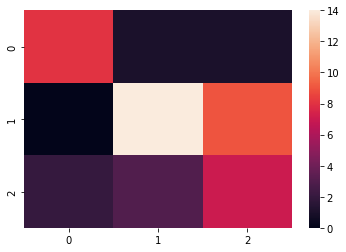

<Figure size 432x288 with 0 Axes>

In [21]:
X = wine['data']
Y = wine['target']

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25)

# build the classifier
model = KNeighborsClassifier()

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Let's try bagging.


Training Classification Report:

               precision    recall  f1-score   support

           0       0.91      0.95      0.93        43
           1       0.78      0.77      0.78        52
           2       0.73      0.71      0.72        38

    accuracy                           0.81       133
   macro avg       0.81      0.81      0.81       133
weighted avg       0.81      0.81      0.81       133


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.87      0.81      0.84        16
           1       0.78      0.74      0.76        19
           2       0.42      0.50      0.45        10

    accuracy                           0.71        45
   macro avg       0.69      0.68      0.68        45
weighted avg       0.73      0.71      0.72        45


Testing Confusion Matrix:



<Figure size 432x288 with 0 Axes>

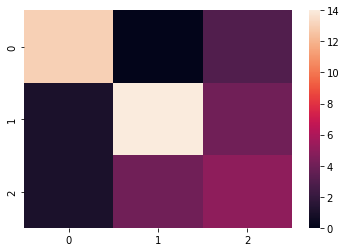

<Figure size 432x288 with 0 Axes>

In [33]:
# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25)

# build the classifier
model = BaggingClassifier(base_estimator = KNeighborsClassifier(), n_estimators = 100)

# fit the classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the training set
predictedY = model.predict(trainX)

# print quality metrics
print('\nTraining Classification Report:\n\n', classification_report(trainY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))

# predict the labels of the test set
predictedY = model.predict(testX)

print('\nTesting Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))
plt.figure()